<a href="https://colab.research.google.com/github/Malek9876/LLM-Based-Text-Classification/blob/main/Sentiment_Analysis_Using_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
%pip install --upgrade pip
%pip install kagglehub
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

# Install the required libraries
%pip install pandas numpy nltk scikit-learn transformers matplotlib seaborn
#%pip uninstall torch torchvision torchaudio -y
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


print('Data source import complete.')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://download.pytorch.org/whl/cu121
Note: you may need to restart the kernel to use updated packages.
Data source import complete.


# Sentiment Analysis on Kaggle sentiment analysis dataset
sentiment analysis tasks on kaggle sentiment analysis dataset using simple machine learning model: Naive bayes


## Including needed libraries

In [2]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


# --------------- HELPING LIBRARIES ----------------
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# ------------- Pytorch Librairies ---------------
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel



In [3]:
torch.cuda.is_available()

True

## Uploading Data

In [4]:
train_dataset = path+'/train.csv'
test_dataset = path+'/test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

True
True


In [5]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')


In [6]:
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


## Data Preprocessing

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4815 entries, 0 to 4814
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            3534 non-null   object 
 1   text              3534 non-null   object 
 2   sentiment         3534 non-null   object 
 3   Time of Tweet     3534 non-null   object 
 4   Age of User       3534 non-null   object 
 5   Country           3534 non-null   object 
 6   Population -2020  3534 non-null   float64
 7   Land Area (Km²)   3534 non-null   float64
 8   Density (P/Km²)   3534 non-null   float64
dtypes: float64(3), object(6)
memory usage: 338.7+ KB


#### Handling null values

In [9]:
train_df.isnull().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [10]:
train_df = train_df.dropna()
train_df.isnull().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [11]:
test_df.isnull().sum()

textID              1281
text                1281
sentiment           1281
Time of Tweet       1281
Age of User         1281
Country             1281
Population -2020    1281
Land Area (Km²)     1281
Density (P/Km²)     1281
dtype: int64

In [12]:
test_df = test_df.dropna()
test_df.isnull().sum()

textID              0
text                0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

#### Removing stopwords & lowercase all text

In [13]:
# Download necessary NLTK data
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text



In [15]:
# Apply preprocessing on train dataset
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
train_df.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,"i`d responded, going"
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105,sooo sad miss san diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18,boss bullying me...
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164,interview! leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26,"sons ****, couldn`t put releases already bought"


In [16]:
# Apply preprocessing on test dataset
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
test_df.head()

,textID,text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),processed_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,last session day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,noon,21-30,Albania,2877797.0,27400.0,105.0,shanghai also really exciting (precisely -- sk...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,"recession hit veronique branquinho, quit compa..."
3,01082688c6,happy bday!,positive,morning,46-60,Andorra,77265.0,470.0,164.0,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,noon,60-70,Angola,32866272.0,1246700.0,26.0,http://twitpic.com/4w75p - like it!!


## Check Imbalancing

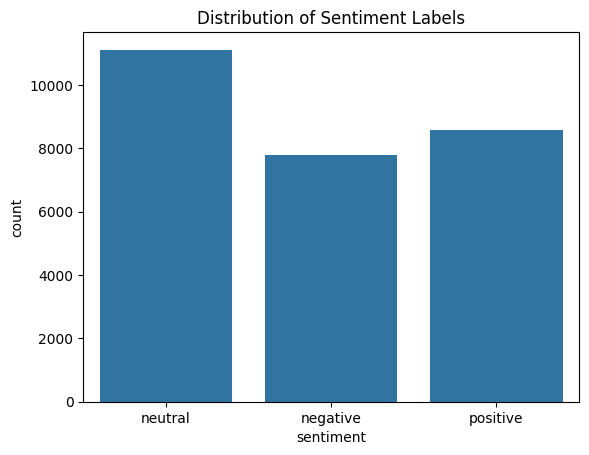

In [17]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

In [18]:
# 1. Transform sentiment into 3 classes
# Example mapping: positive -> 2, neutral -> 1, negative -> 0
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
train_df["sentiment_class"] = train_df["sentiment"].map(sentiment_mapping)
test_df["sentiment_class"] = test_df["sentiment"].map(sentiment_mapping)

# 2. Extract all the values from the 'processed_text' column into a list
trainval_x = train_df["processed_text"].tolist()
trainval_y = train_df["sentiment_class"].tolist()

train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.25, random_state=42)

test_x = test_df["processed_text"].tolist()
test_y = test_df["sentiment_class"].tolist()

In [19]:
print(len(trainval_x),len(val_x),len(test_x))

27480 6870 3534


In [20]:
# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Extract embeddings for all data
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

# Initialize tokenizer, dataset, and dataloader
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
traindataset = TextDataset(train_x, train_y, tokenizer, MAX_LENGTH)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=False)
valdataset = TextDataset(val_x, val_y, tokenizer, MAX_LENGTH)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings
train_embeddings = extract_embeddings(bert, trainloader, device)
train_embeddings =train_embeddings.cpu()

val_embeddings = extract_embeddings(bert, valloader, device)
val_embeddings =val_embeddings.cpu()


In [21]:
print(train_embeddings.size())
print(val_embeddings.size())


torch.Size([20610, 768])
torch.Size([6870, 768])


In [28]:
criterion= nn.CrossEntropyLoss()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings.squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Model Definition
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes, dropout_rate=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)  # Batch Normalization
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)  # Batch Normalization
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, input_ids):
        x = self.fc1(input_ids)
        x = self.bn1(x)  # Apply Batch Normalization
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.bn2(x)  # Apply Batch Normalization
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# training script

def train( model, train_loader, optimizer, epoch,log_interval=50):
    model.train()
    loss_cpu=0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()
        inputs =inputs.detach()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu+= loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

# testing script
def test( model, test_loader,epoch):
    model.eval()
    correct = 0
    total = 0
    test_loss_MSE =0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.cuda(), target.cuda()
            outputs  = model(inputs)
            loss = criterion(outputs,target)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss_MSE+= loss.item()

    test_loss_MSE = test_loss_MSE/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss_MSE, 100.*correct/total

In [34]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.model_selection import ParameterGrid
from torch.optim import AdamW
print("Let us Train.")

# Hyperparameter Grid
param_grid = {
    'hidden_size1': [256, 512],
    'hidden_size2': [128, 256],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [1e-5, 2e-5],
    'weight_decay': [1e-2, 1e-3],
    'batch_size': [16, 32]
}

EPOCHS = 10  # Adjust as needed
criterion = nn.CrossEntropyLoss()

# Results DataFrame
results_df = pd.DataFrame(columns=list(param_grid.keys()) + ['val_accuracy', 'best_epoch'])

# Grid Search
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Create data loaders with current batch size
    trainloader = DataLoader(traindataset, batch_size=params['batch_size'], shuffle=True)
    valloader = DataLoader(valdataset, batch_size=params['batch_size'], shuffle=False)

    # Initialize model and optimizer with current hyperparameters
    model = SentimentClassifier(768, params['hidden_size1'], params['hidden_size2'], 3, params['dropout_rate']).to(device)
    optimizer = AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

    best_val_accuracy = 0
    best_epoch = 0

    for epoch in range(EPOCHS):
        model.train()
        total_loss = 0  # For calculating average training loss

        for batch in trainloader:
            inputs, labels = batch['input_ids'], batch['label']
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * inputs.size(0) # Accumulate weighted loss

        avg_train_loss = total_loss / len(traindataset) # Calculate average training loss
        print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {avg_train_loss}")


        # Validation
        model.eval()
        val_predictions = []
        val_labels = []
        val_loss = 0 # Initialize validation loss
        with torch.no_grad():
            for batch in valloader:
                inputs, labels = batch['input_ids'], batch['label']
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_predictions.extend(predicted.cpu().tolist())
                val_labels.extend(labels.cpu().tolist())
                loss = criterion(outputs, labels)  # Calculate loss for the batch
                val_loss += loss.item() * inputs.size(0) # Accumulate weighted loss


        avg_val_loss = val_loss / len(valdataset)  # Average validation loss
        accuracy = accuracy_score(val_labels, val_predictions)
        print(f"Epoch {epoch+1}/{EPOCHS}, Validation Accuracy: {accuracy}")
        print(classification_report(val_labels, val_predictions))

        # Update best accuracy and epoch
        if accuracy > best_val_accuracy:
            best_val_accuracy = accuracy
            best_epoch = epoch + 1

        scheduler.step(avg_val_loss)

    # Store results
    new_row = params.copy()
    new_row['val_accuracy'] = best_val_accuracy
    new_row['best_epoch'] = best_epoch
    results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

# Print and save results
print("\nHyperparameter Tuning Results:")
print(results_df)
results_df.to_csv("hyperparameter_tuning_results.csv", index=False)

# Train the best model on the full training set (train + val) and evaluate on the test set
best_params = results_df.loc[results_df['val_accuracy'].idxmax()].to_dict()

# Combine train and validation data
train_embeddings_combined = torch.cat([train_embeddings, val_embeddings], dim=0)
train_labels_combined = train_y + val_y # Assuming train_y and val_y are lists

combined_dataset = EmbeddingDataset(train_embeddings_combined, train_labels_combined)
combined_loader = DataLoader(combined_dataset, batch_size=best_params['batch_size'], shuffle=True)

# Initialize the best model
best_model = SentimentClassifier(768, best_params['hidden_size1'], best_params['hidden_size2'], 3, best_params['dropout_rate']).to(device)
optimizer = AdamW(best_model.parameters(), lr=best_params['learning_rate'], weight_decay=best_params['weight_decay'])

# Train the best model on the combined data
for epoch in range(EPOCHS):
    # Training loop (using your train function with combined_loader)
    train_loss = train(best_model, combined_loader, optimizer, epoch)
    print(f"Epoch {epoch+1}/{EPOCHS}, Training Loss: {train_loss}")

# Evaluate the best model on the test set
testdataset = EmbeddingDataset(test_embeddings, test_y)
testloader = DataLoader(testdataset, batch_size=best_params['batch_size'], shuffle=False)
test_loss, test_accuracy = test(best_model, testloader, epoch) # Assuming you have a test function
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Let us Train.
Training with parameters: {'batch_size': 16, 'dropout_rate': 0.2, 'hidden_size1': 256, 'hidden_size2': 128, 'learning_rate': 1e-05, 'weight_decay': 0.01}
Epoch 1/10, Training Loss: 1.0812687121103945
Epoch 1/10, Validation Accuracy: 0.5037845705967977
              precision    recall  f1-score   support

           0       0.44      0.41      0.43      1956
           1       0.50      0.60      0.54      2787
           2       0.58      0.47      0.52      2127

    accuracy                           0.50      6870
   macro avg       0.51      0.49      0.50      6870
weighted avg       0.51      0.50      0.50      6870

Epoch 2/10, Training Loss: 1.001170870148401
Epoch 2/10, Validation Accuracy: 0.5519650655021834
              precision    recall  f1-score   support

           0       0.54      0.44      0.49      1956
           1       0.53      0.61      0.57      2787
           2       0.59      0.58      0.58      2127

    accuracy                          

C:\Users\Admin\AppData\Local\Temp\ipykernel_12920\2240961638.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)


Epoch 1/10, Training Loss: 1.0742069679345394
Epoch 1/10, Validation Accuracy: 0.49912663755458514
              precision    recall  f1-score   support

           0       0.51      0.24      0.33      1956
           1       0.49      0.62      0.55      2787
           2       0.51      0.58      0.54      2127

    accuracy                           0.50      6870
   macro avg       0.50      0.48      0.47      6870
weighted avg       0.50      0.50      0.48      6870

Epoch 2/10, Training Loss: 1.0102564476809994
Epoch 2/10, Validation Accuracy: 0.5420669577874818
              precision    recall  f1-score   support

           0       0.62      0.26      0.37      1956
           1       0.50      0.73      0.59      2787
           2       0.59      0.56      0.57      2127

    accuracy                           0.54      6870
   macro avg       0.57      0.52      0.51      6870
weighted avg       0.56      0.54      0.52      6870

Epoch 3/10, Training Loss: 0.968457293637

KeyboardInterrupt: 

## Evaluation

In [24]:
testdataset = TextDataset(test_x,test_y, tokenizer, MAX_LENGTH)
testloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader, device)
test_embeddings =test_embeddings.cpu()
print('==================== ')
print('Test set = ')
testdataset = EmbeddingDataset(test_embeddings, test_y)
testdataset = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True)
test_loss,accu = test(model, testdataset,epoch)
print('==================== ')

Test set = 

| Validation Epoch #49			Loss: 6.7745 Acc@1: 48.50%


## Questions

**q0/  please analyse the dataset with differents classical machine learning model**

**q1/  please perform a classification with differents classical machine learning model and analyse the performences**

**q2/  please perform a classification with a MLP?**

**q3/  please analyse all the performences and explain which is the best**

**q4/  please use an LLM compare your performences to a LLM**

**q5/  please explain why I choose a BERT embedding instead of the raw text**

**q6/  please read the BERT paper and explain the BERT architecture**

**q7/  please finetue with LORA an LLM to classify the sentiment (optional)**

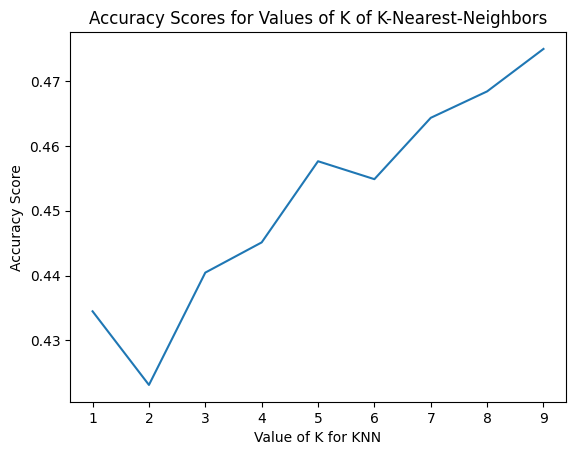

Accuracy of KNN model is : 0.46066779852857953


In [26]:
## KNN
from sklearn.neighbors import KNeighborsClassifier
# Elbow method to find the best K
k_range = range(1, 10)
scores = []
for k in k_range:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(train_embeddings, train_y)
    knn_predictions = knn_model.predict(val_embeddings)
    scores.append(accuracy_score(val_y, knn_predictions))
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of K of K-Nearest-Neighbors')
plt.show()
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(train_embeddings, train_y)
yhat = knn_model.predict(test_embeddings)
print('Accuracy of KNN model is :',accuracy_score(test_y, yhat))

In [ ]:
## QUESTION 0 and 1 :
import sklearn
## LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression

for solver in ['newton-cg', 'lbfgs', 'sag', 'saga']:
    logistic_model = LogisticRegression(max_iter=1000, solver=solver,C=10, random_state=42)
    logistic_model.fit(train_embeddings, train_y)
    logistic_predictions = logistic_model.predict(val_embeddings)
    logistic_accuracy = accuracy_score(val_y, logistic_predictions)
    print(f'Logistic Regression ({solver}) Accuracy: {logistic_accuracy:.2f}')
    yhat = logistic_model.predict(test_embeddings)
    acc = accuracy_score(test_y, yhat)
    print(f'Logistic Regression ({solver}) Accuracy: {acc:.2f}')


Logistic Regression (newton-cg) Accuracy: 0.64
Logistic Regression (lbfgs) Accuracy: 0.64
Logistic Regression (sag) Accuracy: 0.64


In [28]:
## DECISION TREE
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(train_embeddings, train_y)
decision_tree_predictions = decision_tree_model.predict(val_embeddings)
decision_tree_accuracy = accuracy_score(val_y, decision_tree_predictions)
print(f'Decision Tree Validation Accuracy: {decision_tree_accuracy:.2f}')
yhat = decision_tree_model.predict(test_embeddings)
acc = accuracy_score(test_y, yhat)
print(f'Decision Tree Test Accuracy: {acc:.2f}')

Decision Tree Validation Accuracy: 0.42
Decision Tree Test Accuracy: 0.42


In [29]:
## RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42, n_estimators=100,)
random_forest_model.fit(train_embeddings, train_y)
random_forest_predictions = random_forest_model.predict(val_embeddings)
random_forest_accuracy = accuracy_score(val_y, random_forest_predictions)
print(f'Random Forest Validation Accuracy: {random_forest_accuracy:.2f}')
yhat = random_forest_model.predict(test_embeddings)
acc = accuracy_score(test_y, yhat)
print(f'Random Forest Test Accuracy: {acc:.2f}')

Random Forest Validation Accuracy: 0.54
Random Forest Test Accuracy: 0.55


In [ ]:
## SVM with parameters and hyperparameters

from sklearn.svm import SVC
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    for C in [0.1, 1, 10]:
        svm_model = SVC(kernel=kernel, C=C, random_state=42)
        svm_model.fit(train_embeddings, train_y)
        svm_predictions = svm_model.predict(val_embeddings)
        svm_accuracy = accuracy_score(val_y, svm_predictions)
        print(f'SVM ({kernel}, C={C}) Validation Accuracy: {svm_accuracy:.2f}')
        yhat = svm_model.predict(test_embeddings)
        acc = accuracy_score(test_y, yhat)
        print(f'SVM ({kernel}, C={C}) Test Accuracy: {acc:.2f}')



SVM (linear, C=0.1) Validation Accuracy: 0.63
SVM (linear, C=0.1) Test Accuracy: 0.64
SVM (linear, C=1) Validation Accuracy: 0.65
SVM (linear, C=1) Test Accuracy: 0.65


In [26]:

# Assuming you have these already:
# train_embeddings  (Tensor)
# train_y          (List or numpy array)
# val_embeddings    (Tensor)
# val_y            (List or numpy array)
# test_embeddings   (Tensor)
# test_y           (List or numpy array)
# NUM_CLASSES      (int, the number of sentiment classes)
# device           (torch.device("cuda" if torch.cuda.is_available() else "cpu"))
from torch.utils.data import DataLoader, TensorDataset

# 1. Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(train_embeddings, torch.tensor(train_y, dtype=torch.long))
val_dataset = TensorDataset(val_embeddings, torch.tensor(val_y, dtype=torch.long))
test_dataset = TensorDataset(test_embeddings, torch.tensor(test_y, dtype=torch.long))

BATCH_SIZE = 128  # Adjust as needed
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# 2. Define the MLP Model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize the model
input_size = train_embeddings.shape[1]
hidden_size = 512  # Experiment with this value
mlp_model = MLPClassifier(input_size, hidden_size, NUM_CLASSES).to(device)


# 3. Training Loop
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)  # Adjust learning rate

EPOCHS = 10  # Adjust as needed
for epoch in range(EPOCHS):
    for batch in train_loader:
        embeddings, labels = batch
        embeddings, labels = embeddings.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp_model(embeddings)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation
    with torch.no_grad():
        val_predictions = []
        for batch in val_loader:
            embeddings, labels = batch
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = mlp_model(embeddings)
            _, predicted = torch.max(outputs, 1)
            val_predictions.extend(predicted.cpu().numpy())
        val_accuracy = accuracy_score(val_y, val_predictions)
        print(f"Epoch {epoch+1}/{EPOCHS}, Validation Accuracy: {val_accuracy:.4f}")


# 4. Evaluation on Test Set
with torch.no_grad():
    test_predictions = []
    for batch in test_loader:
        embeddings, labels = batch
        embeddings, labels = embeddings.to(device), labels.to(device)
        outputs = mlp_model(embeddings)
        _, predicted = torch.max(outputs, 1)
        test_predictions.extend(predicted.cpu().numpy())
    test_accuracy = accuracy_score(test_y, test_predictions)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(test_y, test_predictions)) # Detailed report

Epoch 1/10, Validation Accuracy: 0.4473
Epoch 2/10, Validation Accuracy: 0.3728
Epoch 3/10, Validation Accuracy: 0.4437
Epoch 4/10, Validation Accuracy: 0.5361
Epoch 5/10, Validation Accuracy: 0.5876
Epoch 6/10, Validation Accuracy: 0.4028
Epoch 7/10, Validation Accuracy: 0.5907
Epoch 8/10, Validation Accuracy: 0.6044
Epoch 9/10, Validation Accuracy: 0.5951
Epoch 10/10, Validation Accuracy: 0.4611
Test Accuracy: 0.4595
              precision    recall  f1-score   support

           0       0.80      0.15      0.25      1001
           1       0.54      0.32      0.40      1430
           2       0.41      0.93      0.57      1103

    accuracy                           0.46      3534
   macro avg       0.58      0.46      0.40      3534
weighted avg       0.57      0.46      0.41      3534



In [42]:
import torch
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

device = 0 if torch.cuda.is_available() else -1
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli", device=device)

candidate_labels = ["positive", "negative", "neutral"]
batch_size = 8  # Start with a smaller batch size; adjust as needed based on GPU memory

n_samples = len(test_df['sentiment'])
llm_predictions = [None] * n_samples
original_labels = list(test_df['sentiment'])

for i in tqdm(range(0, n_samples, batch_size)):
    batch = test_df['processed_text'][i:i + batch_size].tolist()
    valid_batch = [str(text).strip() for text in batch if str(text).strip()]

    if valid_batch:
        try:
            results = classifier(valid_batch, candidate_labels)
            for j, result in enumerate(results):
                llm_predictions[i + j] = result['labels'][0]
        except Exception as e:
            print(f"Error in batch {i}: {e}")
            for j in range(len(batch)):
                llm_predictions[i + j] = "neutral"  # Or another default value
    else:
        for j in range(len(batch)):
            llm_predictions[i + j] = "neutral"

# Filter None values
valid_indices = [i for i, pred in enumerate(llm_predictions) if pred is not None]
filtered_predictions = [llm_predictions[i] for i in valid_indices]
filtered_labels = [original_labels[i] for i in valid_indices]

# Evaluate
print(classification_report(filtered_labels, filtered_predictions))
print("Accuracy:", accuracy_score(filtered_labels, filtered_predictions))

# Convert to numerical labels (if needed)
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
numerical_predictions = [sentiment_mapping.get(pred, -1) for pred in filtered_predictions]

Device set to use cuda:0
100%|██████████| 442/442 [04:28<00:00,  1.65it/s]

              precision    recall  f1-score   support

    negative       0.50      0.91      0.64      1000
     neutral       0.78      0.06      0.11      1428
    positive       0.58      0.85      0.69      1103

    accuracy                           0.55      3531
   macro avg       0.62      0.60      0.48      3531
weighted avg       0.64      0.55      0.44      3531

Accuracy: 0.5454545454545454


In [41]:
# Example
del results
del valid_batch
torch.cuda.empty_cache()  # This is important!